# **Data Preparation**

In [207]:
#import packages
import numpy as np
import pandas as pd
from scipy.integrate import odeint #for handling derivatives
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
from datetime import timedelta

In [208]:
#import dataset

dataset_url = "https://raw.githubusercontent.com/qazwer564/Public-files/main/latimes-la_county-totals-1016.csv"

total_cases = pd.read_csv(dataset_url)

total_cases

,date,county,fips,confirmed_cases,deaths,new_confirmed_cases,new_deaths
0,2020-10-16,Alameda,1,22408,439,38.0,6.0
1,2020-10-16,Alpine,3,3,0,0.0,0.0
2,2020-10-16,Amador,5,272,15,0.0,0.0
3,2020-10-16,Butte,7,2961,50,3.0,0.0
4,2020-10-16,Calaveras,9,333,17,2.0,1.0
...,...,...,...,...,...,...,...
12729,2020-01-26,Solano,95,0,0,NaN,NaN
12730,2020-01-26,Sonoma,97,0,0,NaN,NaN
12731,2020-01-26,Stanislaus,99,0,0,NaN,NaN
12732,2020-01-26,Ventura,111,0,0,NaN,NaN


In [209]:
#Cleaning dataset

#Perform a Data Quality Analysis to find missing values, NaNs etc.
print(total_cases.isnull().sum())
print(total_cases.info())


date                    0
county                  0
fips                    0
confirmed_cases         0
deaths                  0
new_confirmed_cases    58
new_deaths             58
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12734 entries, 0 to 12733
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 12734 non-null  object 
 1   county               12734 non-null  object 
 2   fips                 12734 non-null  int64  
 3   confirmed_cases      12734 non-null  int64  
 4   deaths               12734 non-null  int64  
 5   new_confirmed_cases  12676 non-null  float64
 6   new_deaths           12676 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 696.5+ KB
None


In [210]:
#select data we need

la_cases = total_cases[total_cases['county']=='Los Angeles'][['date','county','confirmed_cases','deaths']]
la_cases.head()

,date,county,confirmed_cases,deaths
18,2020-10-16,Los Angeles,287258,6856
76,2020-10-15,Los Angeles,286217,6834
134,2020-10-14,Los Angeles,285016,6812
192,2020-10-13,Los Angeles,283793,6793
250,2020-10-12,Los Angeles,283023,6773


In [211]:
#use reindex to rolocate rows

index_num = la_cases.date.sort_values().index

la_cases = la_cases.reindex(index_num)

la_cases['date'] = pd.to_datetime(la_cases['date'])

la_cases = la_cases.set_index(['date'])

la_cases

,county,confirmed_cases,deaths
date,,,
2020-01-26,Los Angeles,1,0
2020-01-27,Los Angeles,1,0
2020-01-28,Los Angeles,1,0
2020-01-29,Los Angeles,1,0
2020-01-30,Los Angeles,1,0
...,...,...,...
2020-10-12,Los Angeles,283023,6773
2020-10-13,Los Angeles,283793,6793
2020-10-14,Los Angeles,285016,6812


In [212]:
national_emgergency_date = '2020-03-24'

national_emgergency_date = datetime.strptime(national_emgergency_date, '%Y-%m-%d')

la_cases = la_cases[la_cases.index>=national_emgergency_date]

la_cases

,county,confirmed_cases,deaths
date,,,
2020-03-24,Los Angeles,670,10
2020-03-25,Los Angeles,814,13
2020-03-26,Los Angeles,1230,21
2020-03-27,Los Angeles,1482,26
2020-03-28,Los Angeles,1818,32
...,...,...,...
2020-10-12,Los Angeles,283023,6773
2020-10-13,Los Angeles,283793,6793
2020-10-14,Los Angeles,285016,6812


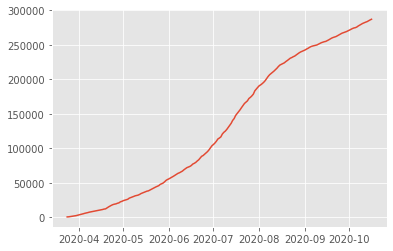

In [213]:
plt.plot(la_cases['confirmed_cases'])

# **Model Building**

In [214]:
# The SEIR model differential equations.
def deriv(y, t, N, beta, gamma, delta):
    S, E, I, R = y
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - delta * E
    dIdt = delta * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [215]:
#building the model and plotting

def plotseird(t, S, E, I, R, D=None, L=None, R0=None, Alpha=None, CFR=None):
  f, ax = plt.subplots(1,1,figsize=(10,4))
  ax.plot(t, S, 'b', alpha=0.7, linewidth=2, label='Susceptible')
  ax.plot(t, E, 'y', alpha=0.7, linewidth=2, label='Exposed')
  ax.plot(t, I, 'r', alpha=0.7, linewidth=2, label='Infected')
  ax.plot(t, R, 'g', alpha=0.7, linewidth=2, label='Recovered')
  if D is not None:
    ax.plot(t, D, 'k', alpha=0.7, linewidth=2, label='Dead')
    ax.plot(t, S+E+I+R+D, 'c--', alpha=0.7, linewidth=2, label='Total')
  else:
    ax.plot(t, S+E+I+R, 'c--', alpha=0.7, linewidth=2, label='Total')

  ax.set_xlabel('Time (days)')

  ax.yaxis.set_tick_params(length=0)
  ax.xaxis.set_tick_params(length=0)
  ax.grid(b=True, which='major', c='w', lw=2, ls='-')
  legend = ax.legend(borderpad=2.0)
  legend.get_frame().set_alpha(0.5)
  for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)
  if L is not None:
      plt.title("Lockdown after {} days".format(L))
  plt.show();

  if R0 is not None or CFR is not None:
    f = plt.figure(figsize=(12,4))
  
  if R0 is not None:
    # sp1
    ax1 = f.add_subplot(121)
    ax1.plot(t, R0, 'b--', alpha=0.7, linewidth=2, label='R_0')

    ax1.set_xlabel('Time (days)')
    ax1.title.set_text('R_0 over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax1.yaxis.set_tick_params(length=0)
    ax1.xaxis.set_tick_params(length=0)
    ax1.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

  if Alpha is not None:
    # sp2
    ax2 = f.add_subplot(122)
    ax2.plot(t, Alpha, 'r--', alpha=0.7, linewidth=2, label='alpha')

    ax2.set_xlabel('Time (days)')
    ax2.title.set_text('fatality rate over time')
    # ax.set_ylabel('Number (1000s)')
    # ax.set_ylim(0,1.2)
    ax2.yaxis.set_tick_params(length=0)
    ax2.xaxis.set_tick_params(length=0)
    ax2.grid(b=True, which='major', c='w', lw=2, ls='-')
    legend = ax2.legend()
    legend.get_frame().set_alpha(0.5)
    for spine in ('top', 'right', 'bottom', 'left'):
      ax.spines[spine].set_visible(False)

    plt.show();

In [216]:
# state: S, E, I, R, 
# according to the data on the initial date:
# N: total population of LA county
N = 10039107                 
# E0: initial value of exposed group 
#     (total cases of 2020-3-24 in the LA county data) 
E0 = 670
# I0: initial value of infecious group 
#     (total cases of 2020-3-24 in the LA county data) 
I0 = 670
# Dead0: initial value of deceased group
#       (from the death number of 2020-3-24 in the LA county data)
Dead0 = 11

# Changing parameters

In [217]:
S0 = N - E0 - I0
R0 = Dead0


D = 8.0 # assuming infections lasts 8 days
gamma = 1.0 / D
delta = 1.0 / 14 # incubation period of 14 days
beta = 0.2

#beta = R_0 * gamma  
# R_0 = beta / gamma, so beta = R_0 * gamma
#S0, E0, I0, R0 = N-1, 1, 0, 0  # initial conditions: one exposed

In [218]:
t = range(1,208) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector

# Integrate the SEIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
S, E, I, R = ret.T

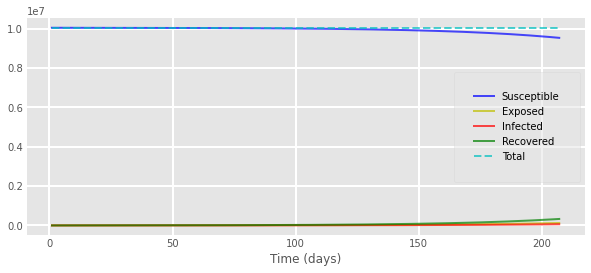

In [219]:
plotseird(t, S, E, I, R)

In [220]:
SEIR = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t})

SEIR['S'] = SEIR['S'].astype('int')
SEIR['E'] = SEIR['E'].astype('int')
SEIR['I'] = SEIR['I'].astype('int')
SEIR['R'] = SEIR['R'].astype('int')

SEIR['Total_confirmed'] = N-SEIR['S']

SEIR = SEIR.set_index(la_cases.index)


SEIR

,S,E,I,R,days,Total_confirmed
date,,,,,,
2020-03-24,10037767,670,670,11,1,1340
2020-03-25,10037636,749,639,92,2,1471
2020-03-26,10037510,819,616,171,3,1597
2020-03-27,10037389,880,601,247,4,1718
2020-03-28,10037269,934,591,321,5,1838
...,...,...,...,...,...,...
2020-10-12,9570387,114042,55505,299182,203,468720
2020-10-13,9559694,116502,56724,306196,204,479413
2020-10-14,9548780,119006,57967,313364,205,490327


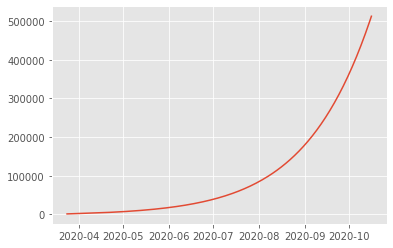

In [221]:
plt.plot(SEIR['Total_confirmed'])

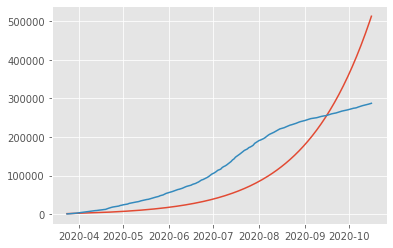

In [222]:
#Comparing two lines 

plt.plot(SEIR['Total_confirmed'])
plt.plot(la_cases['confirmed_cases'])

# **Training**

You can change the time you want to get a model that could be closer to the actual result. You could do that by changing the E0, I0, Dead0 and t.

In [240]:

#########################################################################
#Set up your changes here 


# N: total population of LA county
N = 10039107                 
# E0: initial value of exposed group 
#     (half of the total cases of 2020-3-24 in the LA county data) 
E0 = 670
# I0: initial value of infecious group 
#     (half of the total cases of 2020-3-24 in the LA county data) 
I0 = 670
# Dead0: initial value of deceased group
#       (from the death number of 2020-3-24 in the LA county data)
Dead0 = 13
#D = 8.0 # infections lasts 8 days
#gamma = 1.0 / D
#delta = 1.0 / 14.0  # incubation period of 14 days

S0 = N - E0 - I0
R0 = Dead0

import numpy as np



#set up the preferred range

gamma_range = np.arange(0.1,0.5,0.05)
delta_range = np.arange(0.1,0.9,0.05)
beta_range = np.arange(0.1,0.9,0.05)


#change the days here

t = range(0,207) # Grid of time points (in days)
y0 = S0, E0, I0, R0 # Initial conditions vector


###########################################################################

del S,E,I,R



gamma_list = []
delta_list = []
beta_list = []
error_list = []

import statistics

for gamma in gamma_range:
  for delta in delta_range:
    for beta in beta_range:
      # Integrate the SIR equations over the time grid, t.
      ret = odeint(deriv, y0, t, args=(N, beta, gamma, delta))
      S, E, I, R = ret.T

      SEIR_2 = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t})

      SEIR_2['S'] = SEIR_2['S'].astype('int')
      SEIR_2['E'] = SEIR_2['E'].astype('int')
      SEIR_2['I'] = SEIR_2['I'].astype('int')
      SEIR_2['R'] = SEIR_2['R'].astype('int')

      SEIR_2['Total_confirmed'] = N-SEIR_2['S']

      SEIR_2 = SEIR_2.set_index(la_cases.index)

      error_1 = 0
      error_2 = (statistics.mean(SEIR_2['Total_confirmed']-la_cases['confirmed_cases']))**2
      error = error_1 + error_2

      gamma_list.append(gamma)
      delta_list.append(delta)
      beta_list.append(beta)
      error_list.append(error)

data_dict = {'beta':beta_list,'delta':delta_list,'gamma':gamma_list,'error':error_list}
comparison = pd.DataFrame(data_dict)
comparison.sort_values(by='error')

,beta,delta,gamma,error
1030,0.40,0.10,0.30,1.651916e+07
1334,0.40,0.25,0.35,2.420730e+07
804,0.30,0.20,0.25,2.427566e+07
274,0.20,0.15,0.15,1.055421e+08
1591,0.45,0.25,0.40,1.105220e+08
...,...,...,...,...
207,0.85,0.70,0.10,7.917608e+13
254,0.80,0.85,0.10,7.921262e+13
223,0.85,0.75,0.10,7.953267e+13
239,0.85,0.80,0.10,7.985308e+13


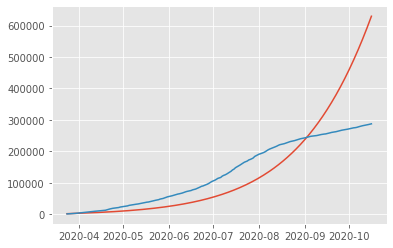

In [244]:

#Change the parameter of beta, delta, gamma here

ret = odeint(deriv, y0, t, args=(N, 0.4, 0.3, 0.1))  #beta, gamma, delta

##########################################################################


S, E, I, R = ret.T

SEIR_2 = pd.DataFrame({'S':S, 'E':E, 'I':I, 'R':R, 'days':t})

SEIR_2['S'] = SEIR_2['S'].astype('int')
SEIR_2['E'] = SEIR_2['E'].astype('int')
SEIR_2['I'] = SEIR_2['I'].astype('int')
SEIR_2['R'] = SEIR_2['R'].astype('int')

SEIR_2['Total_confirmed'] = N-SEIR_2['S']

SEIR_2 = SEIR_2.set_index(la_cases.index)
plt.plot(SEIR_2['Total_confirmed'])
plt.plot(la_cases['confirmed_cases'])